# Géométrie et espace de formes - TP3 - Construction d'atlas et attaches aux données géométriques

<br>
<br>

## 1. Exemples d'appariements difféomorphiques : points, mesures, varifolds

### Codes pour l'implémentation LDDMM

LDDMM signifie 'Large Deformation Diffeomorphic Metric Mapping'.
See: https://www.kernel-operations.io/keops/index.html for a reference. See also: https://www.cs.toronto.edu/~duvenaud/cookbook/ for a review on kernels.

In [64]:
import numpy as np
from collections.abc import Callable

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [16, 10]

import torch
from torch.autograd import grad

# packages optionnels:

# KeOps library for kernel convolutions -- useless for small datasets
#!pip install pykeops 
use_keops = False # use of keops library

# pyvista for displaying 3D graphics
#!pip install 'pyvista[all]'
use_pyvista = False

# geomloss for optimal transport loss functions
#!pip install geomloss

if use_keops:
    from pykeops.torch import LazyTensor

########################
### fonctions noyaux ###
########################

# noyau gaussien (K(x,y)b)_i = sum_j exp(-|xi-yj|^2/sigma^2)bj
def GaussKernel(sigma):
    oos2 = 1/sigma**2
    def K(x,y,b):
        x,y = x[:,None,:],y[None,:,:]
        if use_keops:
            x,y = LazyTensor(x),LazyTensor(y)
        return (-oos2*((x-y)**2).sum(dim=2)).exp()@b
    return K

#Wrapper
def GaussKernel1pt(sigma):
    oos2 = 1/sigma**2
    def K(x,y,b):
        if use_keops:
            x,y = LazyTensor(x),LazyTensor(y)
        print((-oos2*((x-y)**2)).exp())
        return (-oos2*((x-y)**2)).exp()@b
    return K


# noyau de Cauchy (K(x,y)b)_i = sum_j (1/(1+|xi-yj|^2/sigma^2))bj
def CauchyKernel(sigma):
    oos2 = 1/sigma**2
    def K(x,y,b):
        return (1/(1+oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2)))@b
    return K

# somme de noyaux
def SumKernel(*kernels):
    def K(*args):
        return sum(k(*args) for k in kernels)
    return K

# noyau pour les varifolds (K(x,y,u,v)b)_i = sum_j exp(-|xi-yj|^2) <ui,vj>^2 bj
def GaussLinKernel(sigma,lib="keops"):
    oos2 = 1/sigma**2
    def K(x,y,u,v,b):
        Kxy = torch.exp(-oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))
        Sxy = torch.sum(u[:,None,:]*v[None,:,:],dim=2)**2
        return (Kxy*Sxy)@b
    return K

###################################
### solveur d'ODE et optimiseur ###
###################################

# solveur d'EDO explicite
def RalstonIntegrator(nt=10):
    def f(ODESystem,x0,deltat=1.0):
        x = tuple(map(lambda x:x.clone(),x0))
        dt = deltat/nt
        for _ in range(nt):
            xdot = ODESystem(*x)
            xi = tuple(map(lambda x,xdot:x+(2*dt/3)*xdot,x,xdot))
            xdoti = ODESystem(*xi) #Compute through the grad graph a second time, keep in mind the create_graph=True is necessary if one wants to go through
            #the graph a second time
            x = tuple(map(lambda x,xdot,xdoti:x+(.25*dt)*(xdot+3*xdoti),x,xdot,xdoti))
        return x
    return f

# méthode d'optimisation générique
def Optimize(loss,args,niter=5):
    #args is the variable sought to minimize the loss.
    def closure():
        """
        Fonction to compute the gradients at the node of the graph
        """
        optimizer.zero_grad()
        L = loss(*args)
        L.backward()
        return L
    optimizer = torch.optim.LBFGS(args)
    print('performing optimization...')
    for i in range(niter):
        print("iteration ",i+1,"/",niter)
        optimizer.step(closure)
    print("Done.")
    return args

############################
### implémentation LDDMM ###
############################

# définition du Hamiltonien H(p,q)
def Hamiltonian(K):
    def H(p,q):
        return .5*(p * K(q,q,p)).sum()
    return H

# système hamiltonien à résoudre pour le shooting
def HamiltonianSystem(K):
    H = Hamiltonian(K)
    def HS(p,q):
        Gp,Gq = grad(H(p,q),(p,q), create_graph=True, allow_unused = True)
        return -Gq, Gp
    return HS

# shooting = intégration du système hamiltonien
def Shooting(p0,q0,K,delta_t=1.0,Integrator=RalstonIntegrator()):
    """
    Solve the Hamilton equations for q and p.
    Args: 
        - p0 : initial momentum
        - q0 : initial position
        - K : Kernel of the Control vector space
        - delta_t : Time step of the integrator
        - Integrator: Solver employed
    Returns:
        (p,q) at final time.
    """
    return Integrator(HamiltonianSystem(K),(p0,q0),delta_t)

# intégration des équations de flot: retourne l'état final
def Flow(x0,p0,q0,K,delta_t=1.0,Integrator=RalstonIntegrator()):
    HS = HamiltonianSystem(K)
    def FlowEq(x,p,q):
        return (K(x,q,p),) + HS(p,q) #Concatenation
    return Integrator(FlowEq,(x0,p0,q0),delta_t)[0]

# définition de la fonctionnelle à minimiser
def LDDMMloss(q0,K,dataloss,gamma=0.):
    def loss(p0):
        _,q = Shooting(p0,q0,K)
        return gamma * Hamiltonian(K)(p0,q0) + dataloss(q)
    return loss

########################################
### Fonctions d'attaches aux données ###
########################################

# fonction d'attache aux données pour des landmarks
def losslmk(z): #fonction quadratique
    def loss(q):
        return ((q-z)**2).sum() #Distance euclidienne du plan
    return loss

# fonction d'attache aux données pour des nuages de points via le modèle des mesures: Distance entre q et z dans le RKHS
def lossmeas(z,Kw):
    nz = z.shape[0]
    wz = torch.ones(nz,1)
    cst = (1/nz**2)*Kw(z,z,wz).sum()
    def loss(q):
        nq = q.shape[0]
        wq = torch.ones(nq,1)
        return cst + (1/nq**2)*Kw(q,q,wq).sum() + (-2/(nq*nz))*Kw(q,z,wz).sum()
    return loss

# fonction d'attache aux données pour des nuages de points via le transport optimal régularisé
# (nécessite le package geomloss)
def loss_OT(z):
    from geomloss import SamplesLoss
    loss_ = SamplesLoss()
    nz = z.shape[0]
    wz = torch.ones(nz,1)
    def loss(q):
        nq = q.shape[0]
        wq = torch.ones(nq,1)
        return loss_(wq,q,wz,z)
    return loss

# fonction d'attache aux données pour les surfaces triangulées, modèle des varifolds
def lossVarifoldSurf(FS,VT,FT,K):
    # VT: coordonnées des points de la surface cible
    # FS,FT : indices des triangles des surfaces source et cible
    # K : noyau varifold
    def CompCLNn(F,V):
        V0, V1, V2 = V.index_select(0,F[:,0]), V.index_select(0,F[:,1]), V.index_select(0,F[:,2]) #Take the coordinates of the triangle's vertices, along respectively 1st, 2nd and 3rd dimension.
        C, A = .5*(V0+V1+V2), .5*torch.cross(V1-V0,V2-V0) #Center and normal vector to the triangle
        L = (A**2).sum(dim=1)[:,None].sqrt()
        return C,L,A/L #center, square root of area and unit normal vector to the triangle
    CT,LT,NTn = CompCLNn(FT,VT)
    cst = (LT*K(CT,CT,NTn,NTn,LT)).sum()
    def loss(VS):
        CS,LS,NSn = CompCLNn(FS,VS)
        return cst + (LS*K(CS,CS,NSn,NSn,LS)).sum() - 2*(LS*K(CS,CT,NSn,NTn,LT)).sum()
    return loss

# fonction d'attache aux données pour les courbes, modèle des varifolds
def lossVarifoldCurve(FS, VT, FT, K):
    def get_center_length_tangents(F, V):
        V0, V1 = V.index_select(0, F[:, 0]), V.index_select(0, F[:, 1])
        centers, tangents = .5*(V0+V1), V1-V0
        length = (tangents**2).sum(dim=1)[:, None].sqrt()
        return centers, length, tangents / length
    CT, LT, TTn = get_center_length_tangents(FT, VT)
    cst = (LT * K(CT, CT, TTn, TTn, LT)).sum() #Sum over all curves
    def loss(VS):
        CS, LS, TSn = get_center_length_tangents(FS, VS)
        return cst + (LS * K(CS, CS, TSn, TSn, LS)).sum() - 2 * (LS * K(CS, CT, TSn, TTn, LT)).sum()
    return loss

#######################################
### fonctions d'affichage graphique ###
#######################################

def PlotRes2D(z, pts=None):
    """
    Affiche le résultat pour des données landmarks ou nuages de point. z est le vecteur positions des landmarks.
    """
    def plotfun(q0,p0,Kv, showgrid=True):
        """
        Affiche la trajectoire des landmarks. n is the number of point and d the dimension of the space considered.
        Args:
            q0: array(n,d). Initial points coordinates.
            p0: array(n,d). Initial points momentum.
            Kv: kernel of the vector space V.
        """
        p,q = Shooting(p0,q0,Kv) #Get the trajectory
        q0np, qnp = q0.data.numpy(), q.data.numpy() #conversion to numpy
        q0np, qnp, znp = q0.data.numpy(), q.data.numpy(), z.data.numpy() #Conversion to numpy
        #Plot initial points
        plt.plot(znp[:,0],znp[:,1],'^', color = 'green');
        plt.plot(q0np[:,0],q0np[:,1],'+');
        plt.plot(qnp[:,0],qnp[:,1],'o');
        plt.axis('equal');
        if showgrid:
            X = get_def_grid(p0,q0,Kv)
            plt.plot(X[0],X[1],'k',linewidth=.25);
            plt.plot(X[0].T,X[1].T,'k',linewidth=.25); 
        n, d = q0.shape
        nt = 20
        Q = np.zeros((n,d,nt))
        for i in range(nt):
            t = i/(nt-1)
            Q[:,:,i] = Shooting(t*p0,q0,Kv)[1].data.numpy()
        plt.plot(Q[:,0,:].T,Q[:,1,:].T,'y');
        if type(pts)!=type(None): #Allows to put the fisher image on the plot.
            phipts = Flow(pts,p0,q0,Kv).data
            plt.plot(phipts.numpy()[:,0],phipts.numpy()[:,1],'.b',markersize=.1);
    return plotfun

# fonction d'affichage pour des données de type surface triangulée
def PlotRes3D(VS,FS,VT,FT):
    def plotfun(q0,p0,Kv, showgrid=True):
        p,q = Shooting(p0,q0,Kv) #Get the trajectory
        q0np, qnp = q0.data.numpy(), q.data.numpy() #Conversion to numpy
        FSnp,VTnp, FTnp = FS.data.numpy(),  VT.data.numpy(), FT.data.numpy() 
        if use_pyvista:
            import pyvista as pv
            p = pv.Plotter()
            opacity = 1
            p.add_mesh(surf_to_pv(q0np,FSnp), color='lightblue', opacity=opacity)
            p.add_mesh(surf_to_pv(qnp,FSnp), color='lightcoral', opacity=opacity)
            p.add_mesh(surf_to_pv(VTnp,FTnp), color='lightgreen', opacity=opacity)
            if showgrid:
                ng = 20
                X = get_def_grid(p0,q0,Kv,ng=ng)
                for k in range(3):
                    for i in range(ng):
                        for j in range(ng):
                            p.add_mesh(lines_from_points(X[:,i,j,:].T))
                    X = X.transpose((0,2,3,1))
            p.show()
        else:
            fig = plt.figure();
            plt.axis('off')
            plt.title('LDDMM matching example')
            ax = Axes3D(fig, auto_add_to_figure=False)
            ax.plot_trisurf(q0np[:,0],q0np[:,1],q0np[:,2],triangles=FSnp,alpha=.5)
            ax.plot_trisurf(qnp[:,0],qnp[:,1],qnp[:,2],triangles=FSnp,alpha=.5)
            ax.plot_trisurf(VTnp[:,0],VTnp[:,1],VTnp[:,2],triangles=FTnp,alpha=.5)
            if showgrid:
                ng = 20
                X = get_def_grid(p0,q0,Kv,ng=ng)
                for k in range(3):
                    for i in range(ng):
                        for j in range(ng):
                            ax.plot(X[0,i,j,:],X[1,i,j,:],X[2,i,j,:],'k',linewidth=.25);
                    X = X.transpose((0,2,3,1))
            fig.add_axes(ax)
    return plotfun

def get_def_grid(p0,q0,Kv,ng=50):
    d = p0.shape[1] #dimension, 2 in the examples below
    p,q = Shooting(p0,q0,Kv)
    q0np, qnp = q0.data.numpy(), q.data.numpy()
    q0np, qnp = q0.data.numpy(), q.data.numpy()
    a = list(np.min(np.vstack((q0np[:,k],qnp[:,k]))) for k in range(d)) #x coordinate
    b = list(np.max(np.vstack((q0np[:,k],qnp[:,k]))) for k in range(d)) #y coordinate
    sz = 0.2 #step size
    lsp = list(np.linspace(a[k]-sz*(b[k]-a[k]),b[k]+sz*(b[k]-a[k]),ng,dtype=np.float32) for k in range(d))
    X = np.meshgrid(*lsp)
    x = np.concatenate(list(X[k].reshape(ng**d,1) for k in range(d)),axis=1)
    phix = Flow(torch.from_numpy(x),p0,q0,Kv).detach().numpy()
    X = phix.transpose().reshape([d]+[ng]*d) #Compute the distorded grid after the flow
    return X

def lines_from_points(points):
    import pyvista as pv
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = points
    cells = np.full((len(points) - 1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points) - 1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly

def surf_to_pv(V,F):
    import pyvista as pv
    nf = F.shape[0]
    F = np.hstack((np.ones((nf,1),dtype="int")*3,F))
    F = F.flatten()
    surf = pv.PolyData(V,F)
    return surfq

### Exemple de matching de landmarks - données "poissons" du TP 2

Poisson original

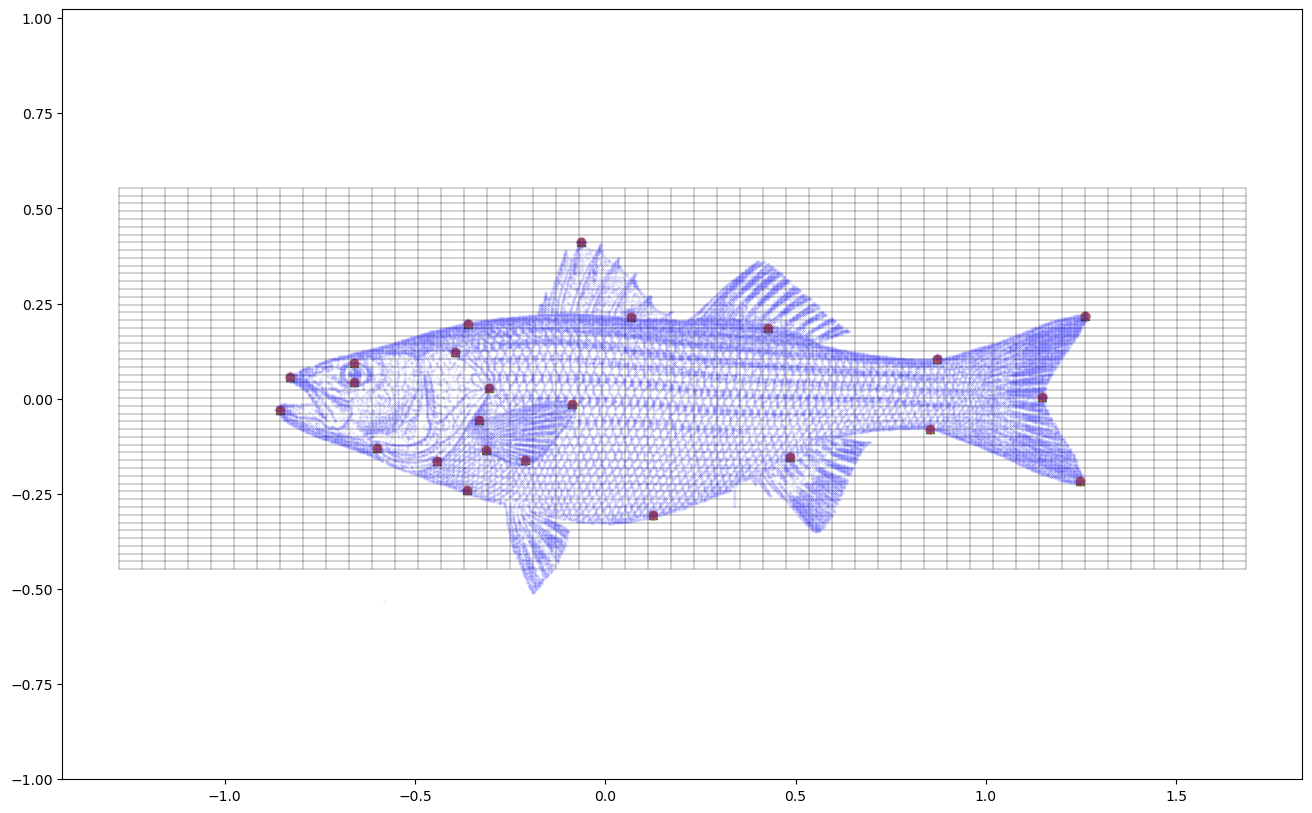

In [5]:
# on charge les données: lmk1 et lmk2 sont respectivements des sous ensembles de pts1 et pts2.
pts1, pts2, lmk1, lmk2 = torch.load('fish.pt')

# définition des points q0 = landmarks du premier poisson
q0 = lmk1.clone().detach().requires_grad_(True) #requires_grad = true necessary to get the grad w.r.t q_0

Kv = CauchyKernel(sigma=.35)

# initialisation des vecteurs moments p0
p0 = torch.zeros(q0.shape, requires_grad=True)

PlotRes2D(lmk1,pts1)(q0,p0,Kv)

Il y a une ambiguïté sur les dimensions du noyau $K(q,q)$. De toutes les manières, le hamiltonien peut se lire des deux manières suivantes: 
$H(q,p) = \frac{1}{2}\langle p_t, K(q,q) p_t \rangle_{(\mathbb{R}^{d})^N} = \sum_{i,j} K(q_i,q_j) \langle p_i, p_j \rangle_{\mathbb{R}^d}$, où $N$ est le nombre de points et $d$ leurs dimension. Une autre manière de le voir encore est que $K(q_i,q_j) = k(q_i,q_j) I_d$, auquel cas on a bien 
$K(q,q) \in \mathbb{R}^{N \times d}$.

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


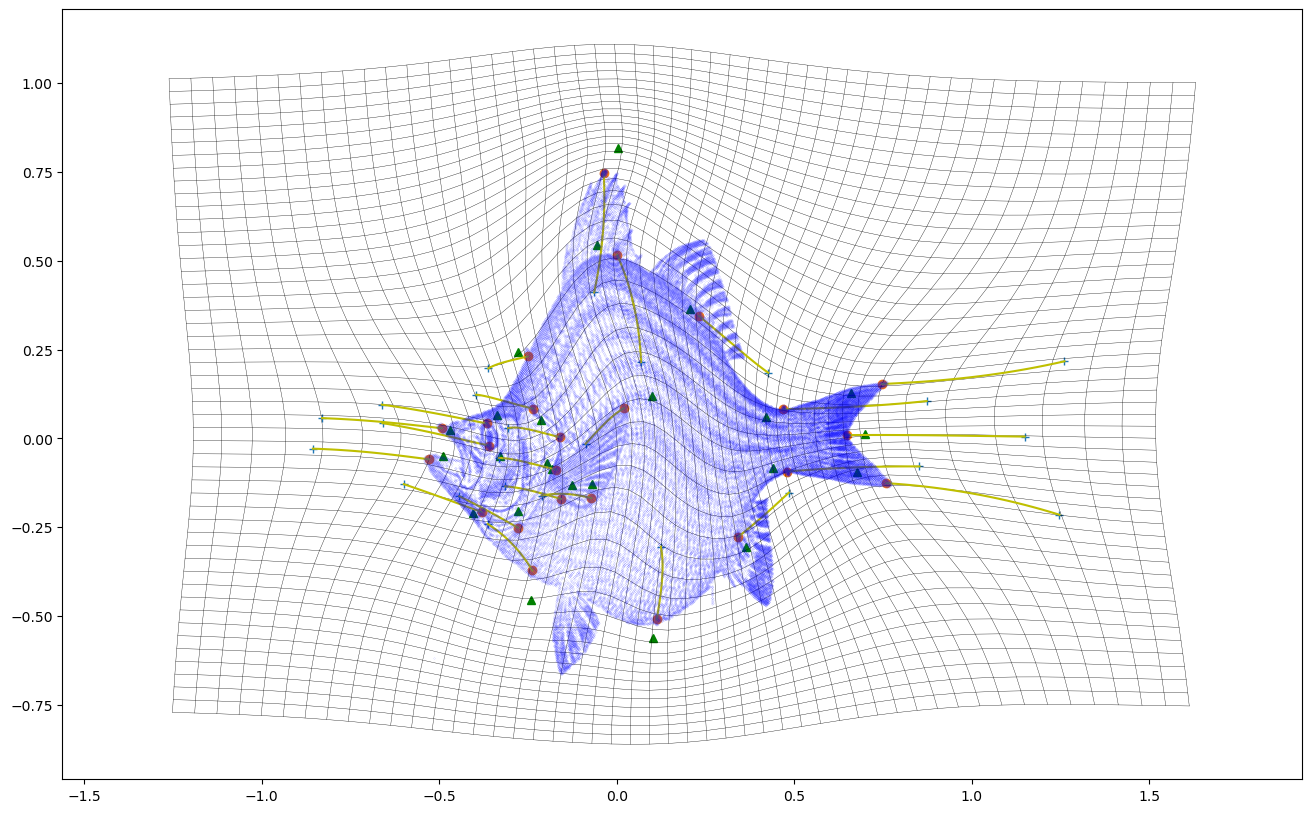

In [6]:
# définition des points q0 = landmarks du premier poisson
q0 = lmk1.clone().detach().requires_grad_(True) #requires_grad = true necessary to get the grad w.r.t q_0

# définition du noyau Kv
#Kv = GaussKernel(sigma=.25)
Kv = CauchyKernel(sigma=.35)
#Kv = SumKernel(CauchyKernel(sigma=.5), CauchyKernel(sigma=.25), CauchyKernel(sigma=.125))

# terme d'attache aux données
Dataloss = losslmk(lmk2)

# fonction globale à minimiser
loss = LDDMMloss(q0,Kv,Dataloss, gamma = .5)

# initialisation des vecteurs moments p0
p0 = torch.zeros(q0.shape, requires_grad=True)

# optimisation de p0
p0, = Optimize(loss,[p0])

# affichage du résultat
PlotRes2D(lmk2,pts1)(q0,p0,Kv) #pts1 are here to put the fish image on the plot.

### Exemple de matching de nuages de points / courbes

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


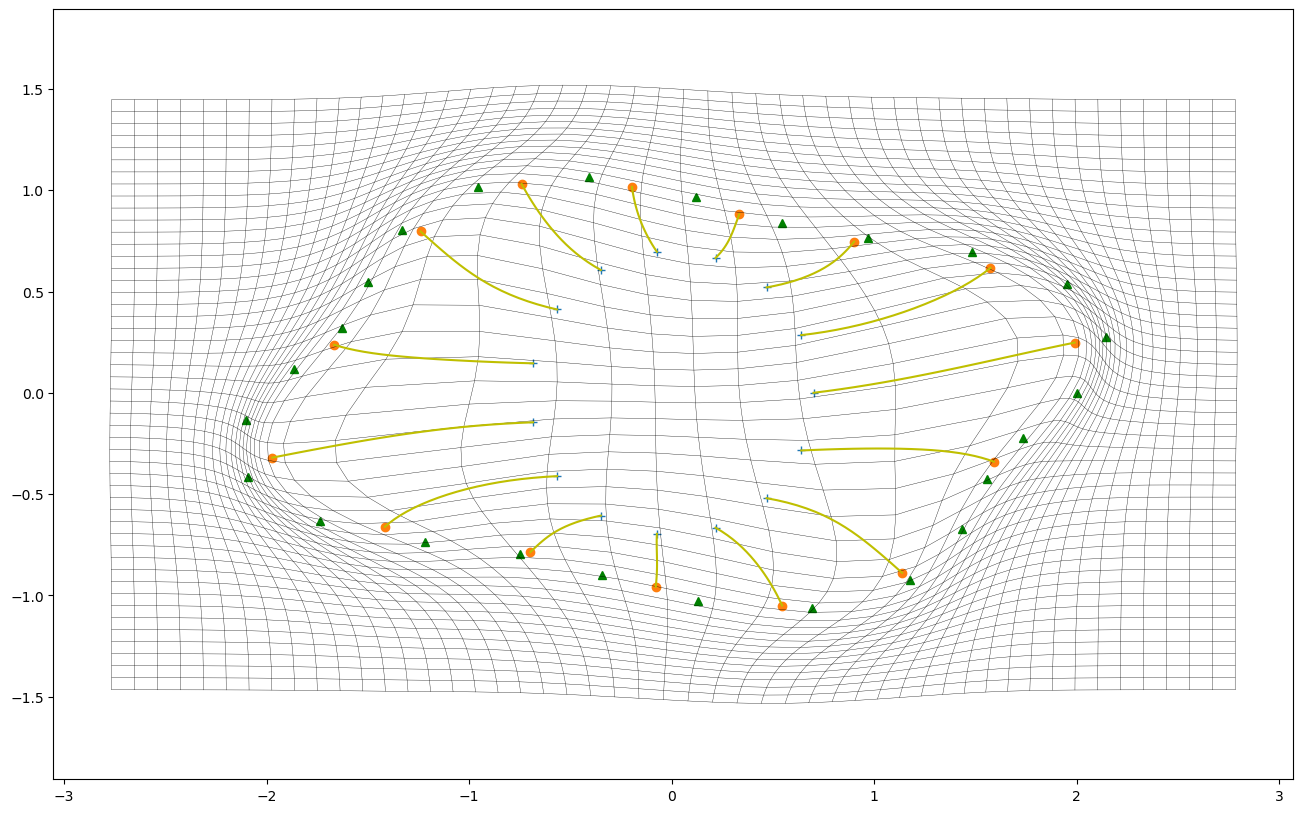

In [7]:
VS, FS, VT, FT = torch.load('curves.pt')
q0 = VS.clone().detach().requires_grad_(True)
Kv = GaussKernel(sigma=.5)

#Dataloss = lossmeas(VT,GaussKernel(sigma=.5))
#Dataloss = loss_OT(VT)
Dataloss = lossVarifoldCurve(FS, VT, FT, GaussLinKernel(sigma=.5))

loss = LDDMMloss(q0,Kv,Dataloss, gamma = 1)
p0 = torch.zeros(q0.shape, requires_grad=True)
p0, = Optimize(loss,[p0])

# affichage du résultat
PlotRes2D(VT)(q0,p0,Kv)

### Exemple de matching de surfaces - modèle des varifolds

C:\Users\hugon\AppData\Local\Temp\ipykernel_13504\3004519241.py:199: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Cross.cpp:67.)
  C, A = .5*(V0+V1+V2), .5*torch.cross(V1-V0,V2-V0) #Center and normal vector to the triangle


performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


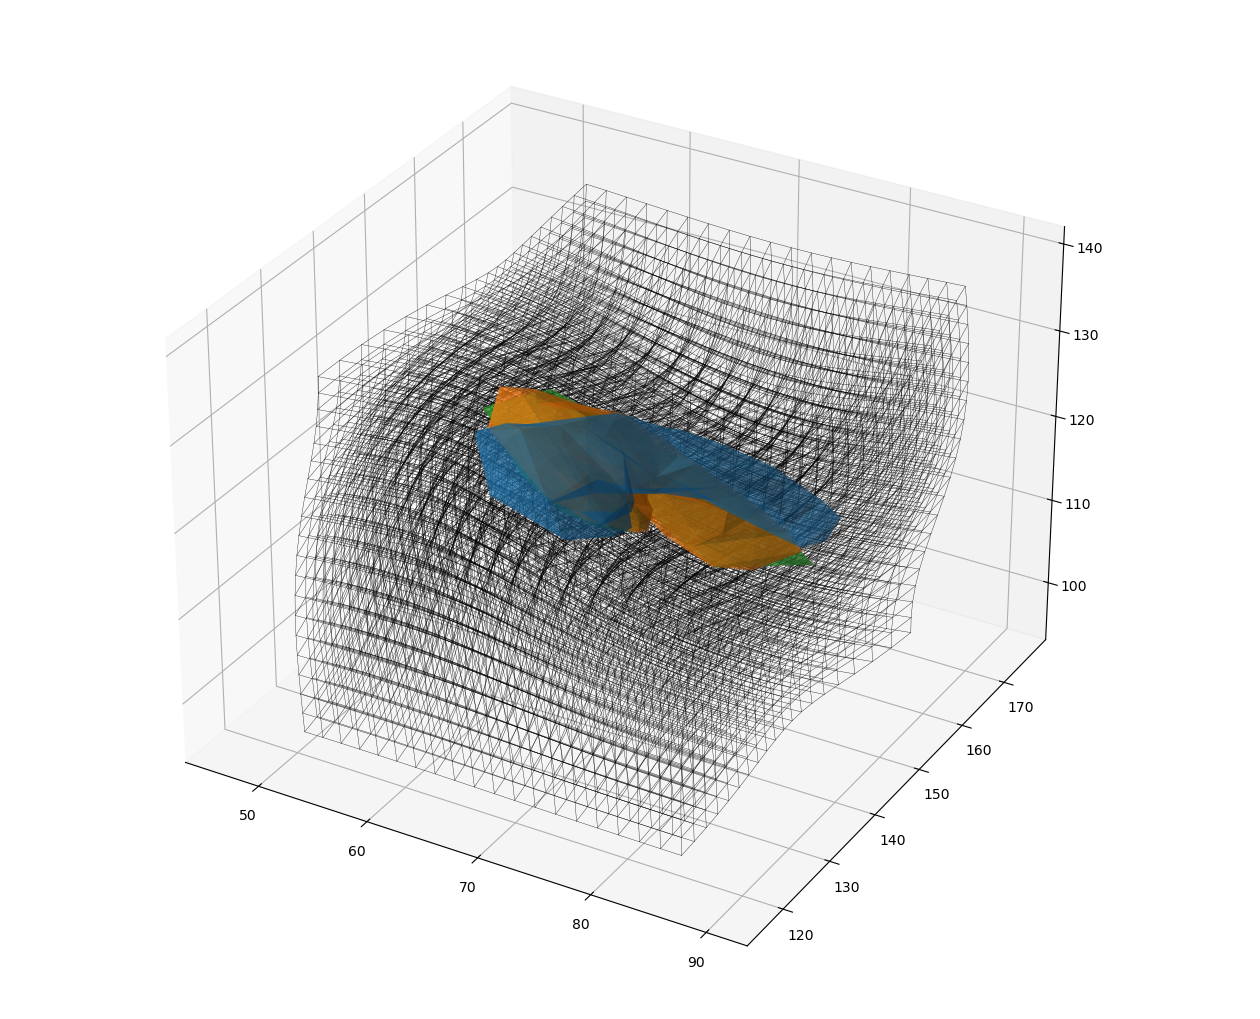

In [8]:
VS,FS,VT,FT = torch.load('hippos_reduc_reduc.pt') # ou 'hippos_reduc.pt' pour une surface moins simplifiée
q0 = VS.clone().detach().requires_grad_(True)
Kv = GaussKernel(sigma=20)
Dataloss = lossVarifoldSurf(FS,VT,FT,GaussLinKernel(sigma=20))
loss = LDDMMloss(q0,Kv,Dataloss)
p0 = torch.zeros(q0.shape, requires_grad=True)
p0, = Optimize(loss,[p0]) #Find the right momentum

# affichage du résultat
PlotRes3D(VS,FS,VT,FT)(q0,p0,Kv)

<br>
<br>

## 1. Mise en évidence de la courbure de l'espace de formes


__Question 1__ : On va construire ici un triangle dans l'espace des landmarks et le comparer à  un triangle euclidien.
Choisir trois configurations de points simples dans le plan, et calculer les appariements deux à  deux pour une métrique LDDMM fixée.
Calculer les longueurs des côtés du triangle (distances géodésiques entre les points), 
ainsi que les angles aux sommets à  l'aide de la métrique locale. Comparer avec les valeurs qu'on obtiendrait dans le cas d'un triangle euclidien.
Montrer que si la taille du noyau $\sigma$ tend vers 0, on se rapproche de la situation euclidienne.

L'angle se calcule par la formule: $\cos(\theta) = \displaystyle\frac{p^{T}_1 K(q,q) p_2}{\sqrt{p^{T}_1K(q,q) p_1}\sqrt{p^{T}_2K(q,q) p_2}}$, tandis que la longueur du segment $[q_0,q_1]$ par $d(q_0,q_1) = \underset{\dot{\phi} = v \circ \phi, \, \phi(0) = q_0, \phi(1) = q_1}{\inf} \int_{0}^1 ||v||^2_V dt + \frac{1}{2}||q_1 - q_{\text{lmk}}||^2$. En réalité, les équations de la dynamique sont symplectiques, et par conséquent le hamiltonien $H(q,p)$  associé se conserve le long de la trajectoire. Par ailleurs, rappelons que $||v||^2_V = \frac{1}{2}p(0)^T  K(q(0),q(0)) p(0) = H(q,p) = \text{cst}$

In [31]:
# Question 1
q0 = torch.tensor([[0.,0.], [1.,0.], [0.,1.]]).requires_grad_(True)

def f():
    def g(x,y,z):
        return z
    return g
K = GaussKernel1pt(.1)

#1er au 2nd sommet
data_loss = losslmk(q0[1])
loss = LDDMMloss(q0[0],K,dataloss=data_loss)
p0 = torch.zeros((q0[0].shape), requires_grad=True)
p0,=Optimize(loss,[p0])
L12 = (p0*K(q0[0],q0[0],p0)).sum()
L12_true = torch.sum((q0[0] - q0[1])**2)
print("Dans l'espace de formes, la longueur entre le 1 er et 2 nd côté du triangle est", L12.item())
print("Dans l'espace euclidien, la longueur entre le 1 er et 2 nd côté du triangle est", L12_true.item())

performing optimization...
iteration  1 / 5
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1.], grad_fn=<ExpBackward0>)
tensor([1., 1

## 2. Construction d'atlas

Nous allons voir ici comment réaliser un modèle de construction d'atlas pour l'étude d'une population de formes. Autrement dit, à partir de la donnée de $N$ formes similaires $x^k$, nous cherchons à obtenir conjointement une forme moyenne (le prototype) $\bar x$ et des déformations optimales $\phi^k$ entre $\bar x$ et $x^k$. La donnée finale des $N$ transformations $\phi^k$ permet alors d'effectuer une étude statistique sur la population.

Nous supposerons que les formes considérées sont paramétrables par des ensembles de points: $x^k=(x_i^k)_{1\leq i\leq n_k}\in(\R^d)^{n_k}$.

### a) Premier modèle : déformations paramétrées par les points du prototype

Nous considérons d'abord  la fonctionnelle suivante:
$$\tilde J(\{\phi^k\}_{1\leq k\leq N},\bar x)=\sum_{k=1}^N\left\{\gamma d_V(\text{Id},\phi^k)^2+A_k(\phi^k(\bar x))\right\},$$
où $V$ est un espace de Hilbert de champs de vecteurs, 
$$d_V(\text{Id},\phi^k)^2=\inf\left\{\int_0^1\|v(t,\cdot)\|_V^2\;dt,\;\;\phi^v(1,\cdot)=\phi^k\right\}$$
avec $\phi^v$ le flot des champs $v(t,\cdot)$,
$\gamma>0$ un paramètre,
et $A_k$ est la fonctionnelle d'attache aux données pour la forme $x^k$, tandis que $\bar x$ est la "forme" (ensemble de points ici) prototype à optimiser. Le nombre de points $n$ de $\bar x$ est fixé.
Pour un tel problème, comme pour le problème d'appariement simple, les transformations optimales $\phi^k$ sont paramétrées par des vecteurs $p_i(0)^k$ (appelés moments initiaux) attachés aux points $\bar x_i$, et le problème revient à minimiser
$$J(\{p^k(0)\}_{1\leq k\leq N},\bar x)=\sum_{k=1}^N\left\{\gamma \, \langle p^k(0)^T K_V(\bar x,\bar x)p^k(0) \rangle+A_k(q^k(1))\right\},$$
où $p^k(t),q^k(t)$ suivent les équations géodésiques (cf 2e TP), avec $q^k(0)=\bar x$.

<br>

__Question 2__ : On va travailler avec des données de types courbes 2D et utiliser l'attache aux données avec la méthode des varifolds : $A_k(z)=\|[z]-[ x^k]\|_{W'}^2$, où $[z]$ désigne le varifold associé à la courbe échantillonnée par les points de $z$, et $\|\cdot\|_{W'}$ la norme de Hilbert duale sur l'espace des varifolds. (N.B. Il n'est pas nécessaire de comprendre le modèle des varifolds pour réaliser ce qui suit ; on peut utiliser cette attache aux données directement)

Adapter le code exemple d'appariement difféomorphique pour obtenir ce modèle de construction d'atlas.

In [78]:
# Question 2
#Wrapper to loss function
def AtlasLDDMMloss(K: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],dataloss: list[Callable], gamma: float=0) -> Callable:
    # fonction similaire à LDDMMloss, pour la construction d'atlas
    # -> doit définir la fonction J(p^k,xbar) du TP
    # arguments : 
    #    K : noyau KV du modèle difféomorphique
    #    dataloss : liste ou t-uple de fonctions d'attache aux données
    #    gamma : paramètre gamma de la fonction J
    # sortie :
    #    loss : fonction définissant J et pouvant Ãªtre appelée sous la forme
    #           loss(p^1,p^2,...,p^N,xbar)

    def loss(p0, xbar):
        Loss = 0
        for k in range(len(dataloss)):
            _, q = Shooting(p0[k],xbar,K)
            Loss += gamma * Hamiltonian(K)(p0,xbar) + dataloss[k](q)
        return Loss
    return loss


__Question 3__ : Le fichier
${\it synth\_20.pt}$ contient une liste ${\sf x}$ de $20$ configurations de $n=44$ points dans le plan. Afficher ces configurations.

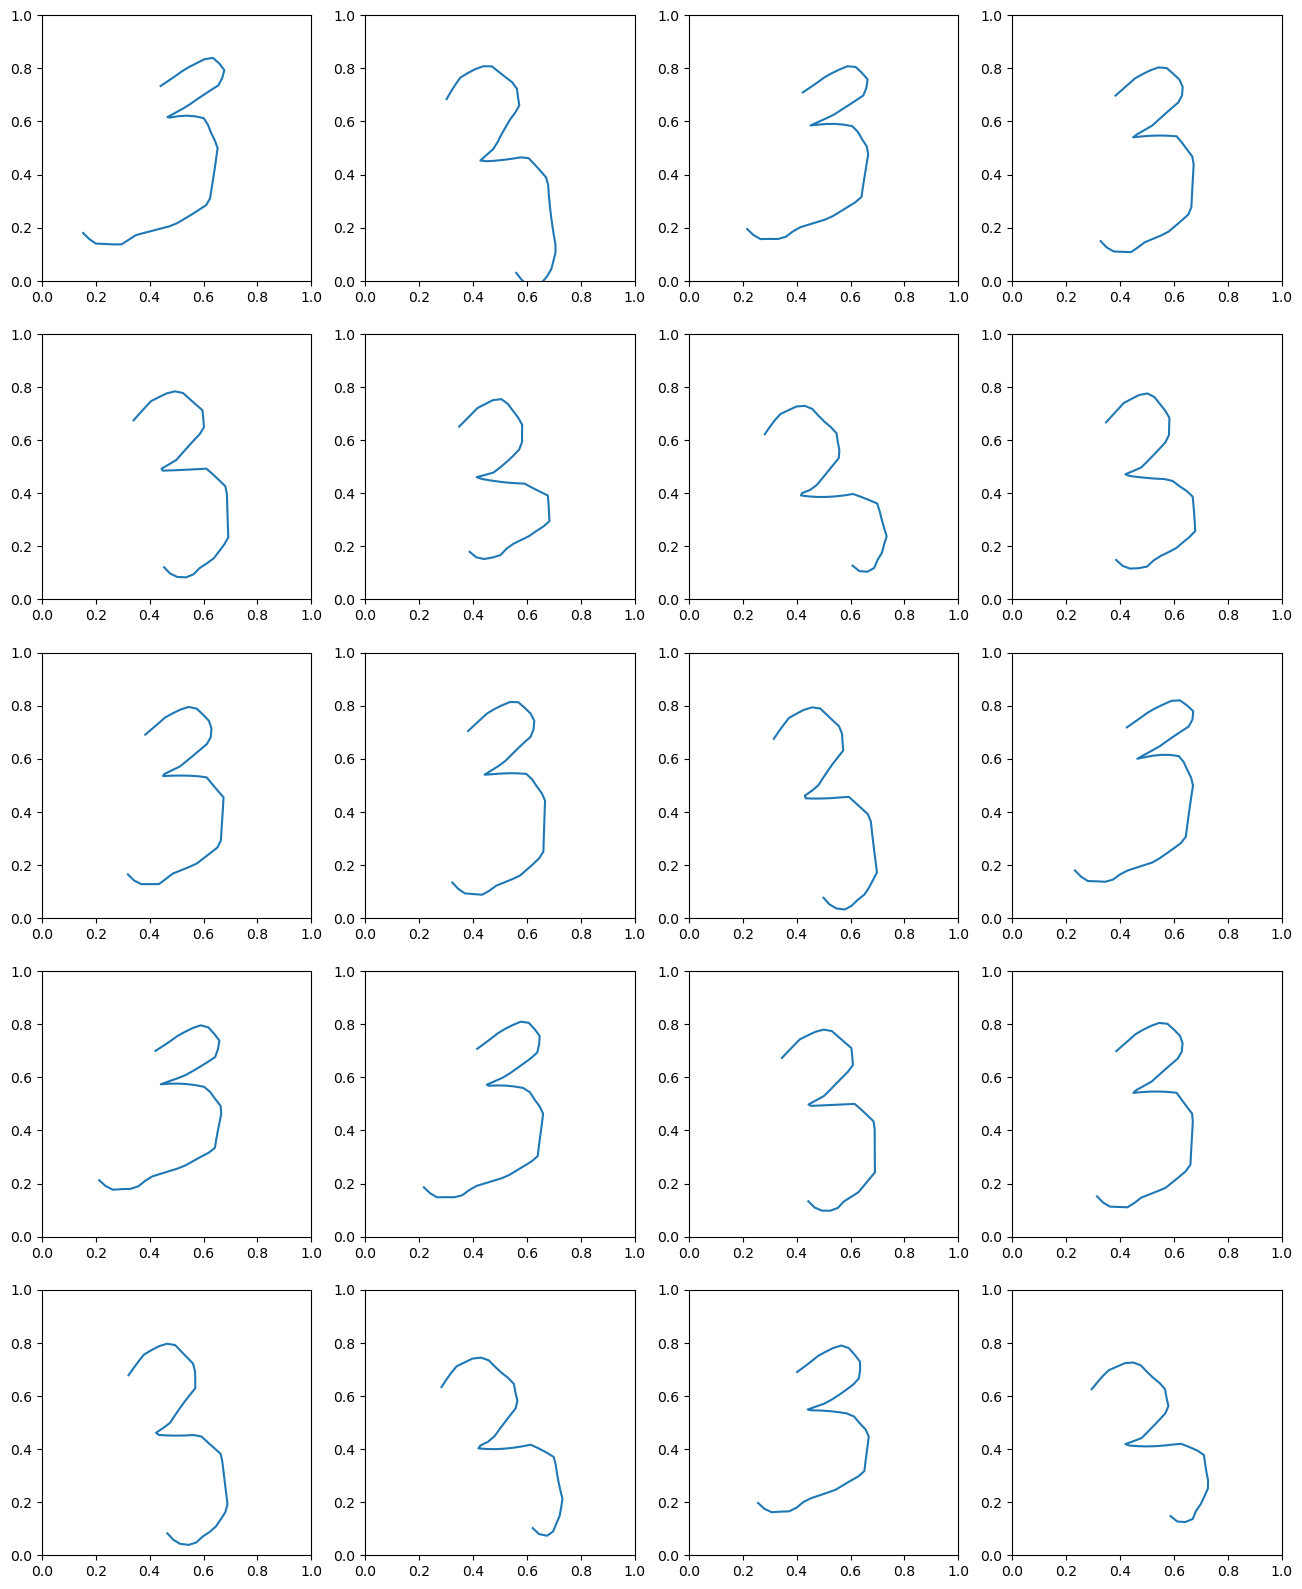

In [79]:
# Question 3 : affichage des données synth_20
plt.figure(figsize=(16,20))
x = torch.load('synth_20.pt')
N = len(x) # N=20
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1])
    plt.axis([0,1,0,1])
plt.show()


__Question 4__ : Tester la méthode de construction d'atlas avec ces données, puis
afficher les positions des points $x_i^k$, $\bar x_i$ et $\phi^k(\bar x_i)$ après minimisation.

In [80]:
# définition des points xbar
xbar = x[0].clone().detach().requires_grad_(True)

nxbar = x[0].shape[0]
FS = torch.tensor(np.array([np.arange(nxbar-1),np.arange(1,nxbar)]).T).contiguous()

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# définition du noyau Kw
Kw = GaussLinKernel(sigma=.25)

# terme d'attache aux données
Dataloss = []
for k in range(N):
    VT = x[k]
    nk = VT.shape[0]
    FT = torch.tensor(np.array([np.arange(nk-1),np.arange(1,nk)]).T).contiguous()
    loss = lossVarifoldCurve(FS, VT, FT, Kw)
    Dataloss.append(loss)

# fonction globale à minimiser
loss = AtlasLDDMMloss(Kv, Dataloss, gamma=0.1)

# initialisation des vecteurs moments p0
p0 = torch.zeros((N, *xbar.shape), requires_grad=True)

# optimisation de p0 et xbar
p0, xbar = Optimize(loss,[p0,xbar])

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


affichage pour chaque observation des 3 courbes :
prototype (bleu), déformation du prototype (rouge), et observation (noir pointillé)
affichage pour les 4 premières observations,
du résultat du matching, avec trajectoires des points de contrôle et déformation de la grille


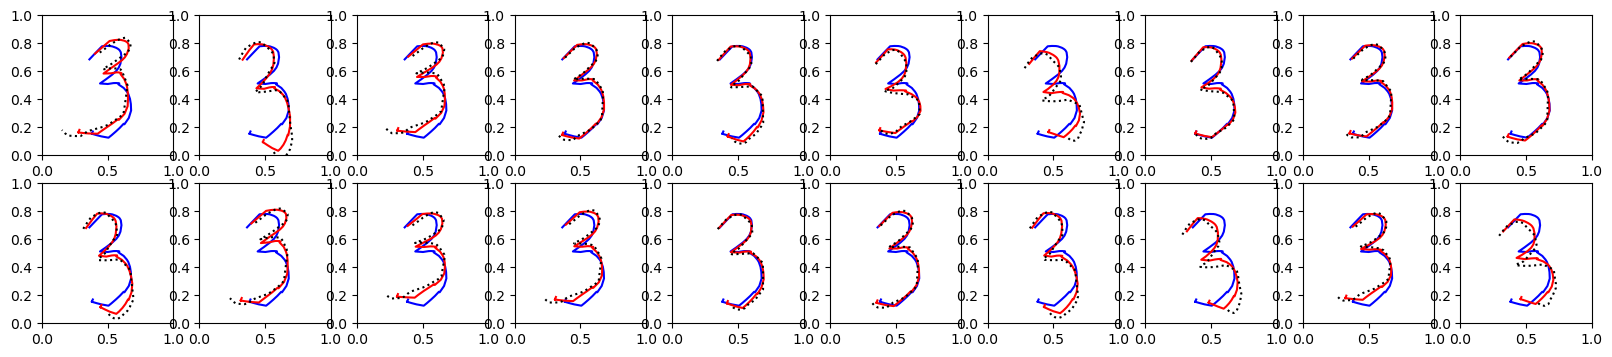

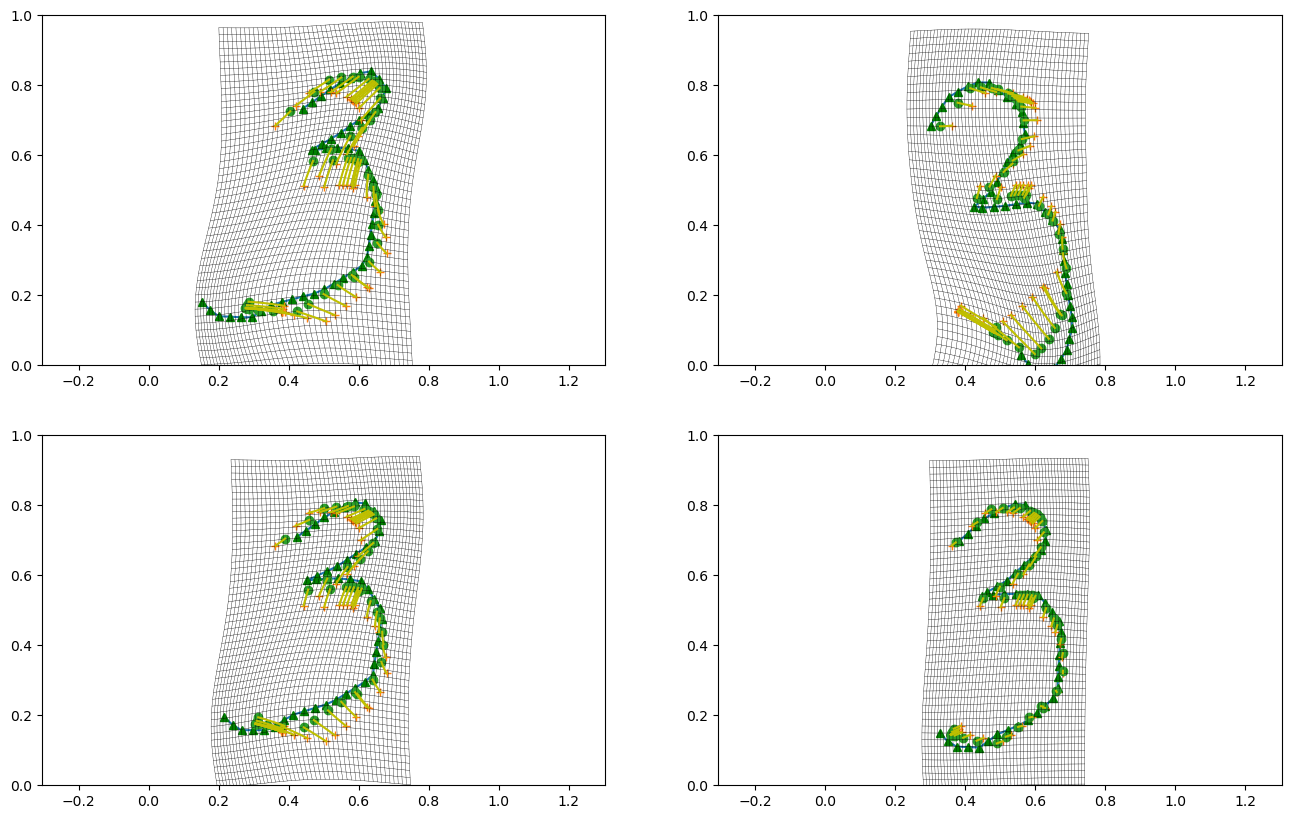

In [81]:
# affichage des résultats :

print("affichage pour chaque observation des 3 courbes :")
print("prototype (bleu), déformation du prototype (rouge), et observation (noir pointillé)")
N = len(x) # N=20
plt.figure(figsize=(20,4))
for k in range(N):
    plt.subplot(2,10,k+1)
    plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"b")
    p,q = Shooting(p0[k],xbar,Kv)
    plt.plot(q.detach()[:,0],q.detach()[:,1],"r")
    plt.plot(x[k][:,0],x[k][:,1],"k:")
    plt.axis([0,1,0,1])

print("affichage pour les 4 premières observations,") 
print("du résultat du matching, avec trajectoires des points de contrôle et déformation de la grille")
plt.figure()
for k in range(4):
    plt.subplot(2,2,k+1)
    plt.plot(x[k][:,0],x[k][:,1])
    plotfun = PlotRes2D(x[k])
    plotfun(xbar,p0[k],Kv)
    plt.axis([0,1,0,1])

plt.show()

__Question 5__ : A partir des vecteurs $p^k(0)$, réaliser une Analyse en Composantes Principales (utiliser la fonction PCA fournie) afin d'extraire les directions principales de déformation de la population. Afficher les formes correspondant Ã  la moyenne et aux deux premières directions principales de déformation.

In [254]:
# Question 5

from numpy import mean,cov,cumsum,dot,linalg,size,flipud,argsort

def pca(X: torch.Tensor,numpc: int=0):
    # perform Principal Component Analysis of data matrix X
    # computing eigenvalues and eigenvectors of covariance matrix
    M = (X-mean(X.T,axis=1)).T # subtract the mean (along columns)
    [latent,coeff] = linalg.eig(cov(M))
    p = size(coeff,axis=1)
    idx = argsort(latent) # sorting the eigenvalues
    idx = idx[::-1]       # in ascending order
    # sorting eigenvectors according to the sorted eigenvalues
    coeff = coeff[:,idx]
    latent = latent[idx] # sorting eigenvalues
    if numpc < p and numpc >= 0:
        coeff = coeff[:,range(numpc)] # cutting some PCs if needed
    score = dot(coeff.T,M) # projection of the data in the new space
    return coeff,score,latent

from sklearn.base import TransformerMixin, BaseEstimator

class PCA(TransformerMixin, BaseEstimator):
    def __init__(self, kernel: str = 'linear', n_comp:int = 2):
        self.kernel = kernel
        self.n_comp = n_comp

        self.coeff = None
        self.latent = None
        self.score = None


    def fit(self, X: torch.Tensor, y: torch.Tensor = None):
        # perform Principal Component Analysis of data matrix X
        # computing eigenvalues and eigenvectors of covariance matrix
        self.X_ = X
        M = (X-mean(X.T,axis=1)).T # subtract the mean (along columns)
        self.Gram_ = cov(M)
        [latent,coeff] = linalg.eig(self.Gram_)
        p = size(coeff,axis=1)
        idx = argsort(latent) # sorting the eigenvalues
        idx = idx[::-1]       # in ascending order
        # sorting eigenvectors according to the sorted eigenvalues
        self.coeff = coeff[:,idx]
        self.latent = latent[idx] # sorting eigenvalues
        if self.n_comp < p and self.n_comp >= 0:
            self.coeff = coeff[:,range(self.n_comp)] # cutting some PCs if needed
        self.score = dot(self.coeff.T,M) # projection of the data in the new space
        self.coeff = self.coeff.astype("float")
        return self

    def transform(self, X_test: torch.Tensor):
        M = (X_test - mean(X_test.T, axis = 1)).T
        Gram = M@(self.X_ - mean(self.X_.T, axis = 1))
        return Gram@self.coeff

    def inverse_transform(self, X: torch.Tensor):
        assert X.shape[1] == self.n_comp, f'Error, input {str(X)} should be of dimension {self.n_comp}.'
        return (X@self.coeff.T).real


In [255]:
n, d = p0[0].shape
N = len(p0)
X = np.zeros((N,n*d))
for k in range(N):
    X[k,:] = p0[k].detach().flatten()

In [256]:
coeff,score,latent = pca(X,numpc=N)
coeff = coeff.real

__Question 6__ : Calculer les $C(i,k)$ pour $1\leq i\leq N$ et $1\leq k\leq 3$ correspondant aux coordonnées des données projetées sur les trois premiers axes principaux, puis visualiser la population de formes dans ces coordonnées projetées.

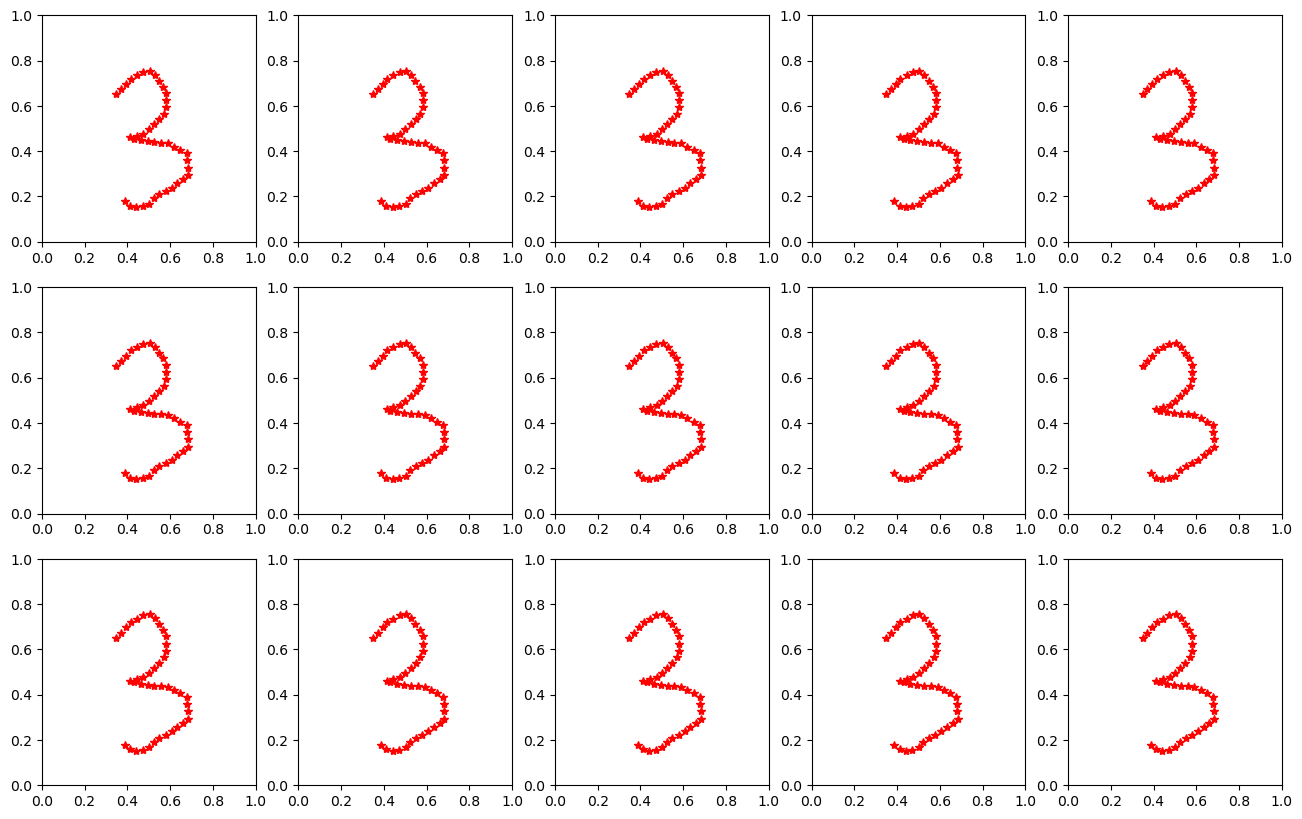

In [259]:
ncomp, ndisp = 3, 5
p0_bar = mean(X,axis=0)
k = 1
for pca_index in range(ncomp):
    sigma_pca = np.sqrt(np.real(latent[pca_index]))
    for alpha in np.linspace(-2*sigma_pca, 2*sigma_pca, ndisp):
        p0_mode = p0_bar + alpha * coeff[:,pca_index]
        p0_mode = torch.tensor(p0_mode.reshape(n,d).astype("float32"), requires_grad=True)
        p,q = Shooting(p0_mode,xbar,Kv)
        plt.subplot(ncomp,ndisp,k)
        plt.plot(q.detach()[:,0],q.detach()[:,1],"*r")
        plt.axis([0,1,0,1])
        k += 1
plt.show()

### b) Deuxième modèle : dissociation des points de contrôle et du prototype

A présent on introduit des variables supplémentaires $(c_i)_{1\leq i\leq n_c}$ 
correspondant aux points de contrôle des déformations $\phi^k$, supposées dissociées des points du prototype. Les déformations $\phi^k$ sont alors paramétrées par ces points et les vecteurs $(p^k_i(0))_{1\leq i\leq n_c}$:
et le problème consiste alors à minimiser
$$J(\{p^k(0)\}_{1\leq k\leq N},\bar x,\textbf{c})=\sum_{k=1}^N\left\{\gamma \langle p^k(0) K_V(\textbf{c},\textbf{c}) p^k(0)\rangle +A_k(\phi^k(\bar x))\right\}.$$

__Question 6__ : Ecrire les fonctions permettant de calculer la fonctionnelle.
Faire des essais avec les données précédentes, avec par exemple $n_c=3$. Afficher la forme prototype optimale ainsi que les positions des points de contrôle $c_i$.

In [67]:
def AtlasLDDMMloss2(K: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], dataloss: list[Callable], gamma: float=0) -> Callable:
    # fonction similaire à LDDMMloss, pour la construction d'atlas
    # -> doit définir la fonction J(p^k,xbar) du TP
    # arguments : 
    #    K : noyau KV du modèle difféomorphique
    #    dataloss : liste ou t-uple de fonctions d'attache aux données
    #    gamma : paramètre gamma de la fonction J
    # sortie :
    #    loss : fonction définissant J et pouvant être appelée sous la forme
    #           loss(p^1,p^2,...,p^N,xbar)

    def Loss(p0, xbar, c):
        loss=0
        for k in range(len(p0)):
            loss += gamma*Hamiltonian(K)(p0[k], c) + dataloss[k]()
        return loss
    return Loss

In [ ]:
# définition des points xbar
xbar = x[0].clone().detach().requires_grad_(True)

nxbar = x[0].shape[0]
FS = torch.tensor(np.array([np.arange(nxbar-1),np.arange(1,nxbar)]).T).contiguous()

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# définition du noyau Kw
Kw = GaussLinKernel(sigma=.25)

# terme d'attache aux données
Dataloss = []
for k in range(N):
    VT = x[k]
    nk = VT.shape[0]
    FT = torch.tensor(np.array([np.arange(nk-1),np.arange(1,nk)]).T).contiguous()
    loss = lossVarifoldCurve(FS, VT, FT, Kw)
    Dataloss.append(loss)
    
# fonction globale à minimiser
loss = AtlasLDDMMloss2(Kv,Dataloss, gamma=0.1)

nc = 7

# initialisation des vecteurs moments p0
p0 = torch.zeros((N, nc, 2), requires_grad=True)

# initialisation des points de controle c
c = torch.rand(nc,2, requires_grad=True)

# optimisation de p0 et xbar
res = Optimize(loss,[p0,xbar,c],niter=10)
p0 = res[:-2]
xbar = res[-2]
c = res[-1]

In [ ]:
N = len(x) # N=20
for k in range(4):
    plt.subplot(2,2,k+1)
    #plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"*b")
    #plt.plot(x[k][:,0],x[k][:,1],"*k")
    plotfun = PlotRes2D(x[k])
    plotfun(c,p0[k],Kv)
    plt.axis("equal")
plt.show()

## 2. Données réelles - attache aux données de type mesures

Pour terminer nous allons réaliser une étude avec des données de type nuages de points non ordonnés (obtenus ici par un simple seuillage 
des pixels sur les images de chiffres manuscrits).

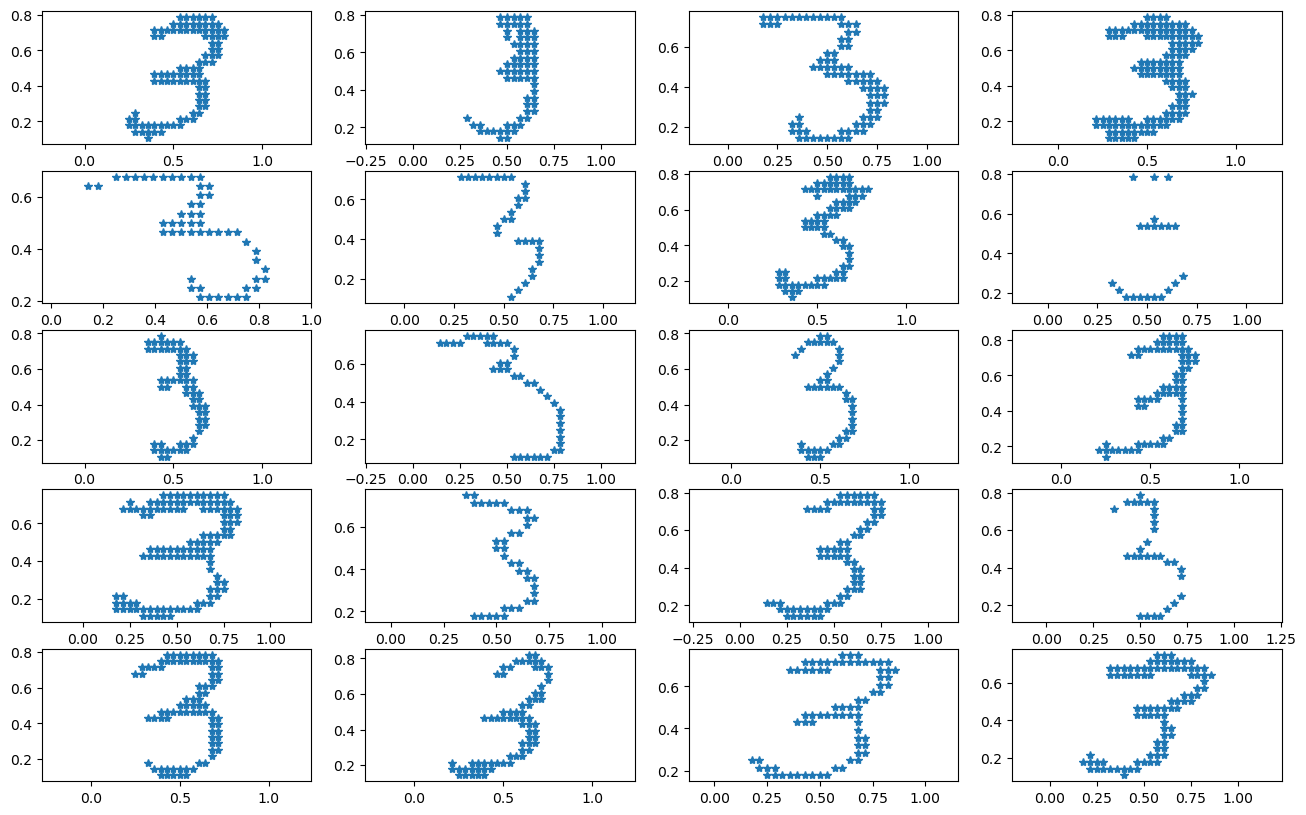

In [73]:
x = torch.load('trois.pt')

for k in range(20):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"*")
    plt.axis("equal")
plt.show()

__Question 8__ : Recommencer l'étude (construction d'atlas et ACP) avec les données du fichier `trois.pt`, en utilisant la fonction `lossmeas` fournie pour calculer les nouvelles fonctionnelles $A_k$. 

N.B. Pour les paramètres on pourra choisir $\sigma_V=0.25$, $\sigma_W=0.1$, $\gamma=0.1$.

In [ ]:
# Question 8


# définition des points xbar
xbar = x[5].clone().detach().requires_grad_(True)

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# définition du noyau Kw
Kw = GaussKernel(sigma=.1)

# terme d'attache aux données
Dataloss = []
N = 20
for k in range(N):
    loss = lossmeas(x[k], Kw)
    Dataloss.append(loss)

# fonction globale à  minimiser
loss = AtlasLDDMMloss(Kv,Dataloss, gamma=0.1)

# initialisation des vecteurs moments p0
p0 = []
for k in range(N):
    p0.append(torch.zeros(xbar.shape, requires_grad=True))

# optimisation de p0 et xbar
res = Optimize(loss,[*p0,xbar],niter=10)
p0 = res[:-1]
xbar = res[-1]

TypeError: optimizer can only optimize Tensors, but one of the params is list

In [ ]:
N = len(x) # N=20
plt.figure(figsize=(16,20))
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"k*")
    plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"b*")
    p,q = Shooting(p0[k],xbar,Kv)
    plt.plot(q.detach()[:,0],q.detach()[:,1],"r*")
    plt.axis([0,1,0,1])
plt.show()